In [1]:
from __future__ import print_function
import argparse
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [2]:
class CnnNet(torch.nn.Module):
    def __init__(self):
        super(CnnNet, self).__init__()

        self.conv1 = torch.nn.Conv2d(1, 32, (3,3))
        self.conv2 = torch.nn.Conv2d(32, 64, (3,3))

        self.drop1 = torch.nn.Dropout2d(0.25)
        self.drop2 = torch.nn.Dropout2d(0.5)

        self.fc1 = torch.nn.Linear(9216, 128)
        self.fc2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.drop1(F.max_pool2d(x, 2))

        x = x.flatten(1)
        x = F.relu(self.fc1(x))
        x = self.drop2(x)
        x = self.fc2(x)

        return F.log_softmax(x, 1)

In [3]:
def train( model, device, train_loader, optimizer,loss_fn, epoch):
    train_loss=0
    model.train()
    no_batches=0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        train_loss+=loss.item()
        no_batches+=1
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
    print("Epoch:", epoch, "sum loss:", train_loss, "batches", no_batches, "loss:", train_loss/no_batches,
         "accuracy:", 100. * correct / len(train_loader.dataset))  
    return train_loss/no_batches, 100. * correct / len(train_loader.dataset)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target)  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, 100. * correct / len(test_loader.dataset)

In [6]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1)

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': 64}
test_kwargs = {'batch_size': 64}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform=transforms.Compose([
        transforms.ToTensor()
        ])
dataset1 = datasets.MNIST('../data', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('../data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

In [7]:
def returnModelAccAndLoss(model, device, train_loader, test_loader, optimizer, loss, epoch, scheduler):
    train_loss=[]
    test_loss=[]
    accuracy_train=[]
    accuracy_test=[]
    for epoch in range(1, epoch+1):
        tr_loss, tr_accuracy=train(model, device, train_loader, optimizer, loss, epoch)
        train_loss.append(tr_loss)
        accuracy_train.append(tr_accuracy)
        tst_loss, tst_accuracy = test(model, device, test_loader)
        test_loss.append(tst_loss)
        accuracy_test.append(tst_accuracy)
        #scheduler.step()
    return train_loss, accuracy_train, test_loss, accuracy_test

In [92]:
epoch=10
model = CnnNet().to(device)
model_params = sum(p.numel() for p in model.parameters())
optimizer = optim.Adadelta(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)
loss = nn.CrossEntropyLoss()
train_loss_1, accuracy_train_1, test_loss_1, test_accuracy_1 = returnModelAccAndLoss(model, device, train_loader, test_loader, optimizer, loss, epoch, scheduler)



Epoch: 1 sum loss: 233.01537080912385 batches 938 loss: 0.24841723966857554 accuracy: 92.31833333333333

Test set: Average loss: 0.0558, Accuracy: 9818/10000 (98%)

Epoch: 2 sum loss: 89.41693266667426 batches 938 loss: 0.09532722032694484 accuracy: 97.19833333333334

Test set: Average loss: 0.0410, Accuracy: 9860/10000 (99%)

Epoch: 3 sum loss: 66.30973361223005 batches 938 loss: 0.07069267975717489 accuracy: 97.875

Test set: Average loss: 0.0381, Accuracy: 9882/10000 (99%)

Epoch: 4 sum loss: 56.91390318115009 batches 938 loss: 0.06067580296497877 accuracy: 98.25

Test set: Average loss: 0.0341, Accuracy: 9890/10000 (99%)

Epoch: 5 sum loss: 48.029251298547024 batches 938 loss: 0.051203892642374224 accuracy: 98.48

Test set: Average loss: 0.0336, Accuracy: 9886/10000 (99%)

Epoch: 6 sum loss: 43.02454366417078 batches 938 loss: 0.04586838343728228 accuracy: 98.63666666666667

Test set: Average loss: 0.0332, Accuracy: 9896/10000 (99%)

Epoch: 7 sum loss: 39.21512120243642 batches 938

In [11]:
from torch.nn.utils import (
  parameters_to_vector as Params2Vec,
  vector_to_parameters as Vec2Params
)

learnt_net = model
theta_ast = Params2Vec(learnt_net.parameters())
print(theta_ast.shape)

infer_net = CnnNet()
theta = Params2Vec(infer_net.parameters())

loss_fn = torch.nn.NLLLoss()

torch.Size([1199882])


In [18]:
def tau(alpha, theta, theta_ast):
    return alpha * theta_ast + (1 - alpha) * theta

In [95]:

train_losses = []
train_accuracy=[]
test_losses=[]
test_accuracy=[]
alphas=[]

for alpha in torch.arange(-2, 3, 0.1):
    loss=[]
    correct=0
    for _, (data, label) in enumerate(train_loader):
         with torch.no_grad():
            Vec2Params(tau(alpha, theta, theta_ast),  infer_net.parameters())
            infer_net.eval()
            prediction = infer_net(data)
            loss.append(loss_fn(prediction, label).item())
            pred = prediction.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(label.view_as(pred)).sum().item()
    #print(loss)
    train_losses.append(np.average(loss))
    train_accuracy.append(correct/len(train_loader.dataset)*100)
    alphas.append(alpha)

for alpha in torch.arange(-2, 3, 0.1):
    loss=[]
    correct=0
    for _, (data, label) in enumerate(test_loader):
         with torch.no_grad():
            Vec2Params(tau(alpha, theta, theta_ast),  infer_net.parameters())
            infer_net.eval()
            prediction = infer_net(data)
            loss.append(loss_fn(prediction, label).item())
            pred = prediction.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(label.view_as(pred)).sum().item()

    test_accuracy.append(correct/len(test_loader.dataset)*100)
    test_losses.append(np.average(loss))
            




50 50


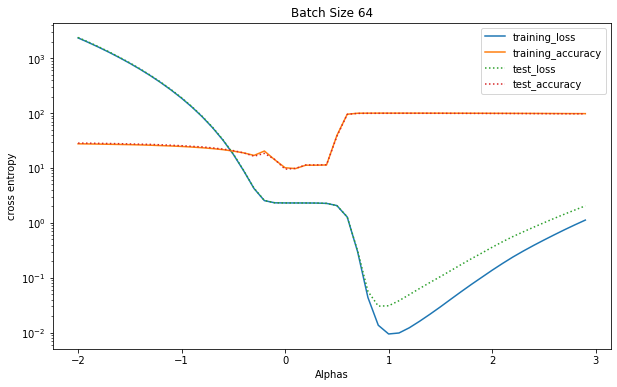

In [97]:
import matplotlib.pyplot as plt

print(len(alphas), len(test_losses))

plt1 = plt.figure(figsize=(10, 6))
plt.plot(np.array(alphas), np.array(train_losses), label='training_loss')
plt.plot(np.array(alphas), np.array(train_accuracy), label='training_accuracy')
plt.plot(np.array(alphas), np.array(test_losses), label='test_loss', linestyle = 'dotted')
plt.plot(np.array(alphas), np.array(test_accuracy), label='test_accuracy', linestyle = 'dotted')
plt.yscale('log')
# naming the x axis
plt.xlabel('Alphas')
# naming the y axis
plt.ylabel('cross entropy') 
plt.legend()
plt.title("Batch Size 64")
plt.show()




In [19]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1)

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': 1024}
test_kwargs = {'batch_size': 1024}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform=transforms.Compose([
        transforms.ToTensor()
        ])
dataset1 = datasets.MNIST('../data', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('../data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

In [20]:
epoch=10
model = CnnNet().to(device)
model_params = sum(p.numel() for p in model.parameters())
optimizer = optim.Adadelta(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)
loss = nn.CrossEntropyLoss()
train_loss_1, accuracy_train_1, test_loss_1, test_accuracy_1 = returnModelAccAndLoss(model, device, train_loader, test_loader, optimizer, loss, epoch, scheduler)

Epoch: 1 sum loss: 51.912811160087585 batches 59 loss: 0.8798781552557218 accuracy: 71.26666666666667

Test set: Average loss: 0.2011, Accuracy: 9421/10000 (94%)

Epoch: 2 sum loss: 13.631818175315857 batches 59 loss: 0.2310477656833196 accuracy: 93.26666666666667

Test set: Average loss: 0.0971, Accuracy: 9690/10000 (97%)

Epoch: 3 sum loss: 8.562372840940952 batches 59 loss: 0.14512496340577885 accuracy: 95.72

Test set: Average loss: 0.0685, Accuracy: 9781/10000 (98%)

Epoch: 4 sum loss: 6.6693436577916145 batches 59 loss: 0.11303972301341719 accuracy: 96.68166666666667

Test set: Average loss: 0.0670, Accuracy: 9775/10000 (98%)

Epoch: 5 sum loss: 5.622225880622864 batches 59 loss: 0.09529196407835362 accuracy: 97.195

Test set: Average loss: 0.0541, Accuracy: 9811/10000 (98%)

Epoch: 6 sum loss: 4.8686625100672245 batches 59 loss: 0.08251970356046143 accuracy: 97.48333333333333

Test set: Average loss: 0.0429, Accuracy: 9859/10000 (99%)

Epoch: 7 sum loss: 4.4154218174517155 batch

In [23]:
from torch.nn.utils import (
  parameters_to_vector as Params2Vec,
  vector_to_parameters as Vec2Params
)

learnt_net = model.to(device)
theta_ast = Params2Vec(learnt_net.parameters())

infer_net = CnnNet().to(device)
theta = Params2Vec(infer_net.parameters())

loss_fn = torch.nn.NLLLoss()

In [26]:
train_losses = []
train_accuracy=[]
test_losses=[]
test_accuracy=[]
alphas=[]

for alpha in torch.arange(-2, 3, 0.2):
    loss=[]
    correct=0
    for _, (data, label) in enumerate(train_loader):
         with torch.no_grad():
            data=data.to(device)
            label=label.to(device)
            Vec2Params(tau(alpha, theta, theta_ast),  infer_net.parameters())
            infer_net.eval()
            prediction = infer_net(data)
            loss.append(loss_fn(prediction, label).item())
            pred = prediction.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(label.view_as(pred)).sum().item()
    #print(loss)
    train_losses.append(np.average(loss))
    train_accuracy.append(correct/len(train_loader.dataset)*100)
    alphas.append(alpha)

for alpha in torch.arange(-2, 3, 0.2):
    loss=[]
    correct=0
    for _, (data, label) in enumerate(test_loader):
         with torch.no_grad():
            data=data.to(device)
            label=label.to(device)
            Vec2Params(tau(alpha, theta, theta_ast),  infer_net.parameters())
            infer_net.eval()
            prediction = infer_net(data)
            loss.append(loss_fn(prediction, label).item())
            pred = prediction.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(label.view_as(pred)).sum().item()

    test_accuracy.append(correct/len(test_loader.dataset)*100)
    test_losses.append(np.average(loss))
            

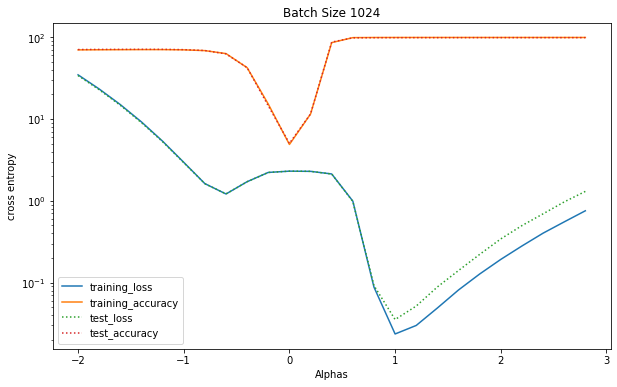

In [29]:
import matplotlib.pyplot as plt

plt1 = plt.figure(figsize=(10, 6))
plt.plot(np.array(alphas), np.array(train_losses), label='training_loss')
plt.plot(np.array(alphas), np.array(train_accuracy), label='training_accuracy')
plt.plot(np.array(alphas), np.array(test_losses), label='test_loss', linestyle = 'dotted')
plt.plot(np.array(alphas), np.array(test_accuracy), label='test_accuracy', linestyle = 'dotted')
plt.yscale('log')
# naming the x axis
plt.xlabel('Alphas')
# naming the y axis
plt.ylabel('cross entropy') 
plt.legend()
plt.title("Batch Size 1024")
plt.show()